In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from collections import defaultdict

In [4]:
pwd!

'/home/ubuntu/MyNotebooks/Smabbler_data_ml_model'

In [5]:
# Load JSON mapping
path_json = 'mapping.json'
with open(path_json) as f_tmp:
    js = json.load(f_tmp)
vals_mapping = {v: k for k, v in js.items()}

In [6]:
# Load data
train_path = 'Train - Export-results-@conditions and diseases-2024-05-09_160046.csv'
test_path = 'Test - Export-results-@conditions and diseases-2024-05-09_160328.csv'

#df_train = pd.read_csv(train_path, sep=';')
df_train = pd.read_csv(train_path, sep=';', low_memory=False)
df_test = pd.read_csv(test_path, sep=';')

In [7]:
# Function to reshape data to features
def reshape_to_features(df, col):
    features_list = []
    
    for group_id, group_df in df.groupby('ID'):
        features_dict = {value:1 for value in group_df[col]}
        features_dict['label_tmp'] = group_df.iloc[0]['label_tmp']
        features_list.append(features_dict)
    
    features_df = pd.DataFrame(features_list).fillna(0)

    return features_df

In [8]:
# Function to train and evaluate RandomForestClassifier and SVC
def train_evaluate_models(df_train, df_test, feature):
    # Define label mappings
    label_counts = pd.DataFrame(df_test.drop_duplicates('ID')['label'].value_counts())
    label_counts['label_name'] = label_counts.index.map(lambda x: vals_mapping[x])
    top_label_map = label_counts[label_counts['count'] >= 10]['label_name'].to_dict()
    
    label_map = defaultdict(lambda: 'other')
    label_map.update(top_label_map)
    
    label_map[285] = 'Diabetes'  # Fix labeling error
    
    # Preprocess data
    df_train['label_tmp'] = df_train['label'].map(lambda x: label_map[x]).astype("category")
    df_test['label_tmp'] = df_test['label'].map(lambda x: label_map[x]).astype("category")
    
    df_train_features = reshape_to_features(df_train, feature)
    df_test_features = reshape_to_features(df_test, feature)
    
    # Ensure both datasets have the same features
    all_features = set(df_train_features.columns) | set(df_test_features.columns)
    df_train_features = df_train_features.reindex(columns=all_features, fill_value=0)
    df_test_features = df_test_features.reindex(columns=all_features, fill_value=0)
    
    # Split data into features and labels
    X_train = df_train_features.drop(columns=['label_tmp'])
    y_train = df_train_features['label_tmp']
    
    X_test = df_test_features.drop(columns=['label_tmp'])
    y_test = df_test_features['label_tmp']
    
    # Train and evaluate RandomForestClassifier
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred_rfc = rfc.predict(X_test)
    accuracy_rfc = rfc.score(X_test, y_test)
    f1_rfc = f1_score(y_test, y_pred_rfc, average='weighted')
    cm_rfc = confusion_matrix(y_test, y_pred_rfc, labels=rfc.classes_, normalize='true')
    
    # Train and evaluate SVC
    svc = SVC()
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    accuracy_svc = svc.score(X_test, y_test)
    f1_svc = f1_score(y_test, y_pred_svc, average='weighted')
    cm_svc = confusion_matrix(y_test, y_pred_svc, labels=svc.classes_, normalize='true')
    
    # Display confusion matrix for RandomForestClassifier
    cm_disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc, display_labels=rfc.classes_)
    fig, ax = plt.subplots()
    ax.set_title('RandomForestClassifier - Feature set: %s' % feature)
    cm_disp_rfc.plot(colorbar=False, cmap='Greys', ax=ax)
    plt.xticks(rotation=45, ha='right')
    fig.set_size_inches(16, 16)
    rf_image_path = '/home/ubuntu/MyNotebooks/Smabbler_data_ml_model/rf_confusion_matrix.png'
    plt.savefig(rf_image_path)
    plt.show()
    plt.gcf().clear()
    
    # Display confusion matrix for SVC
    cm_disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc.classes_)
    fig, ax = plt.subplots()
    ax.set_title('SVC - Feature set: %s' % feature)
    cm_disp_svc.plot(colorbar=False, cmap='Greys', ax=ax)
    plt.xticks(rotation=45, ha='right')
    fig.set_size_inches(16, 16)
    svc_image_path = '/home/ubuntu/MyNotebooks/Smabbler_data_ml_model/svm_confusion_matrix.png'
    plt.savefig(svc_image_path)
    plt.show()
    plt.gcf().clear()
    
    return (accuracy_rfc, f1_rfc), (accuracy_svc, f1_svc)


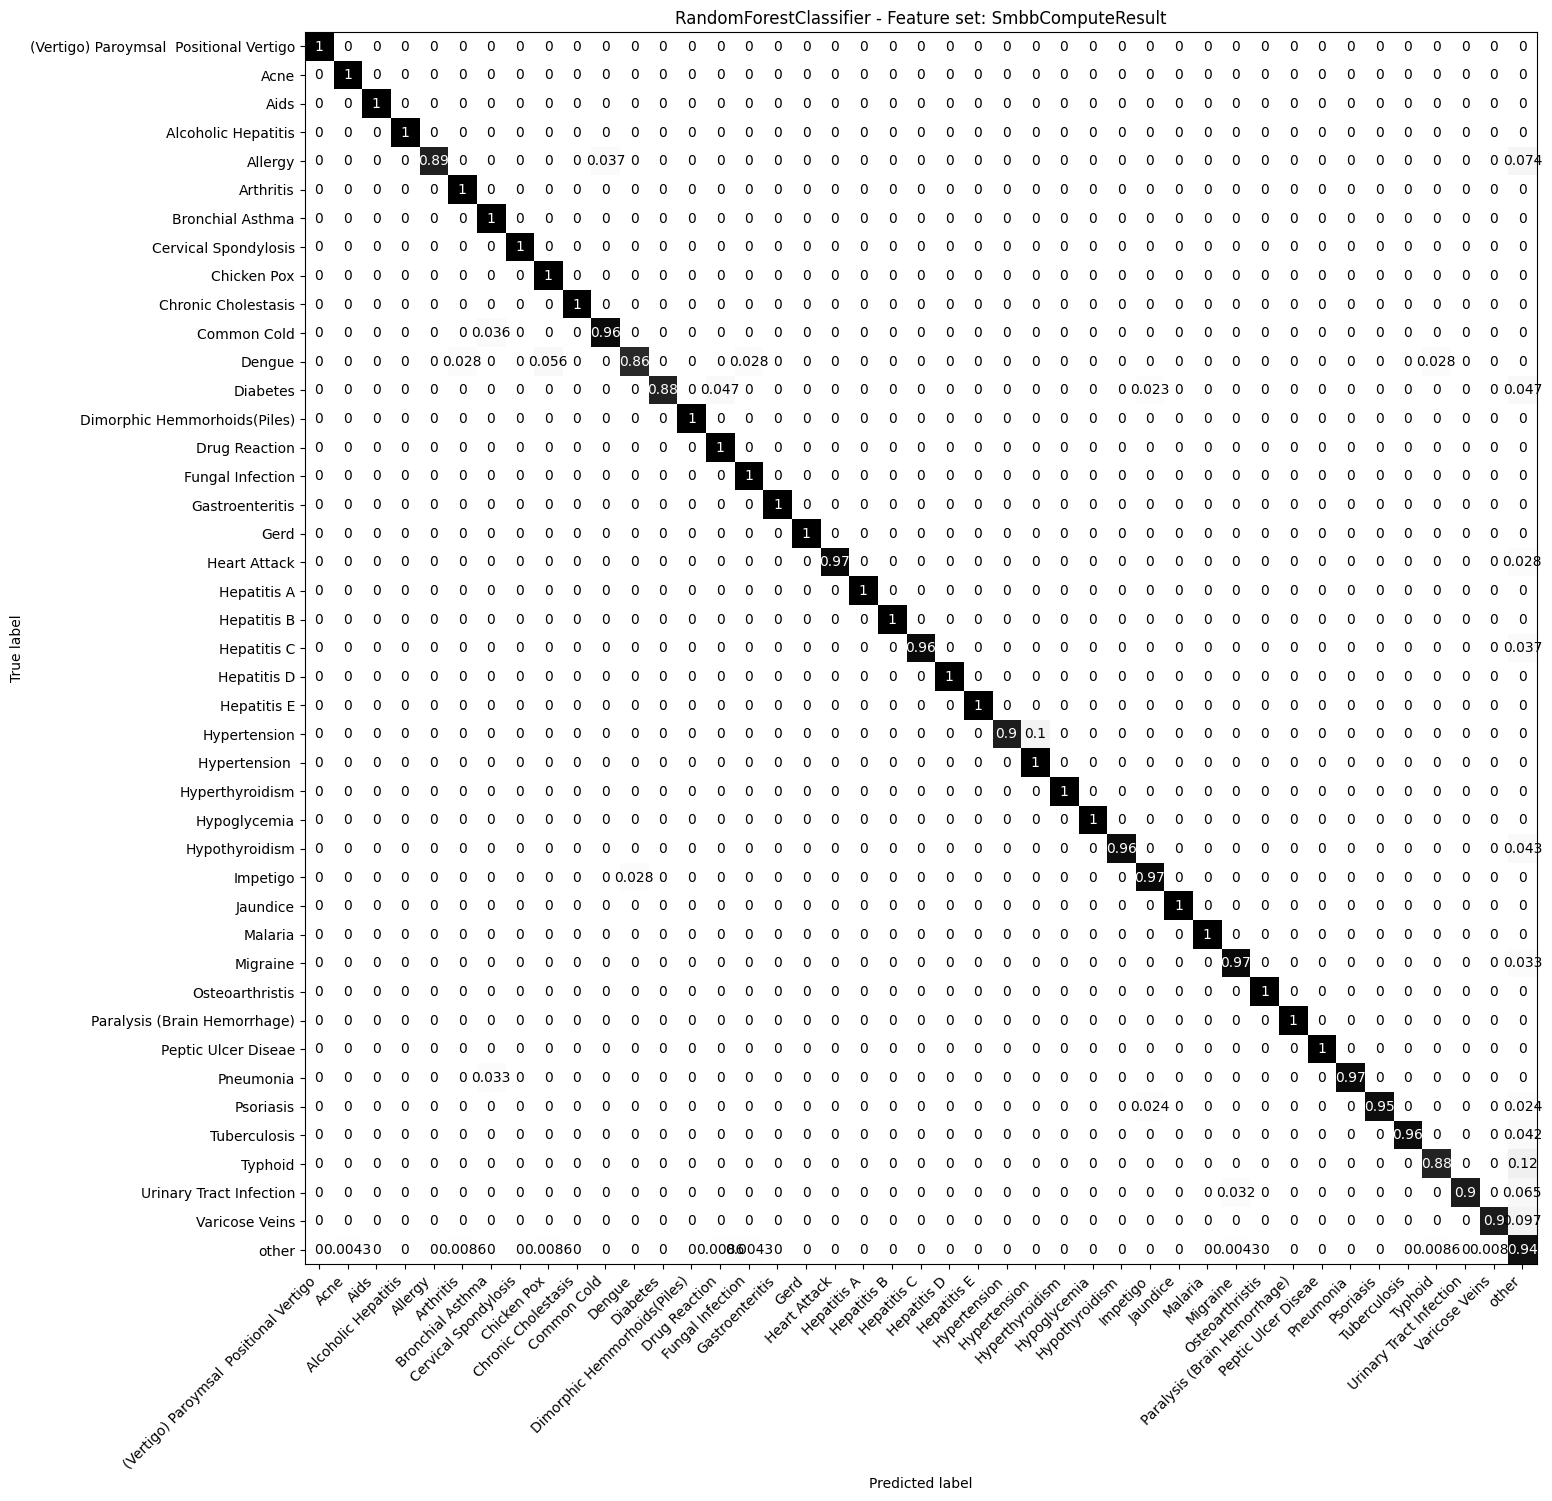

<Figure size 640x480 with 0 Axes>

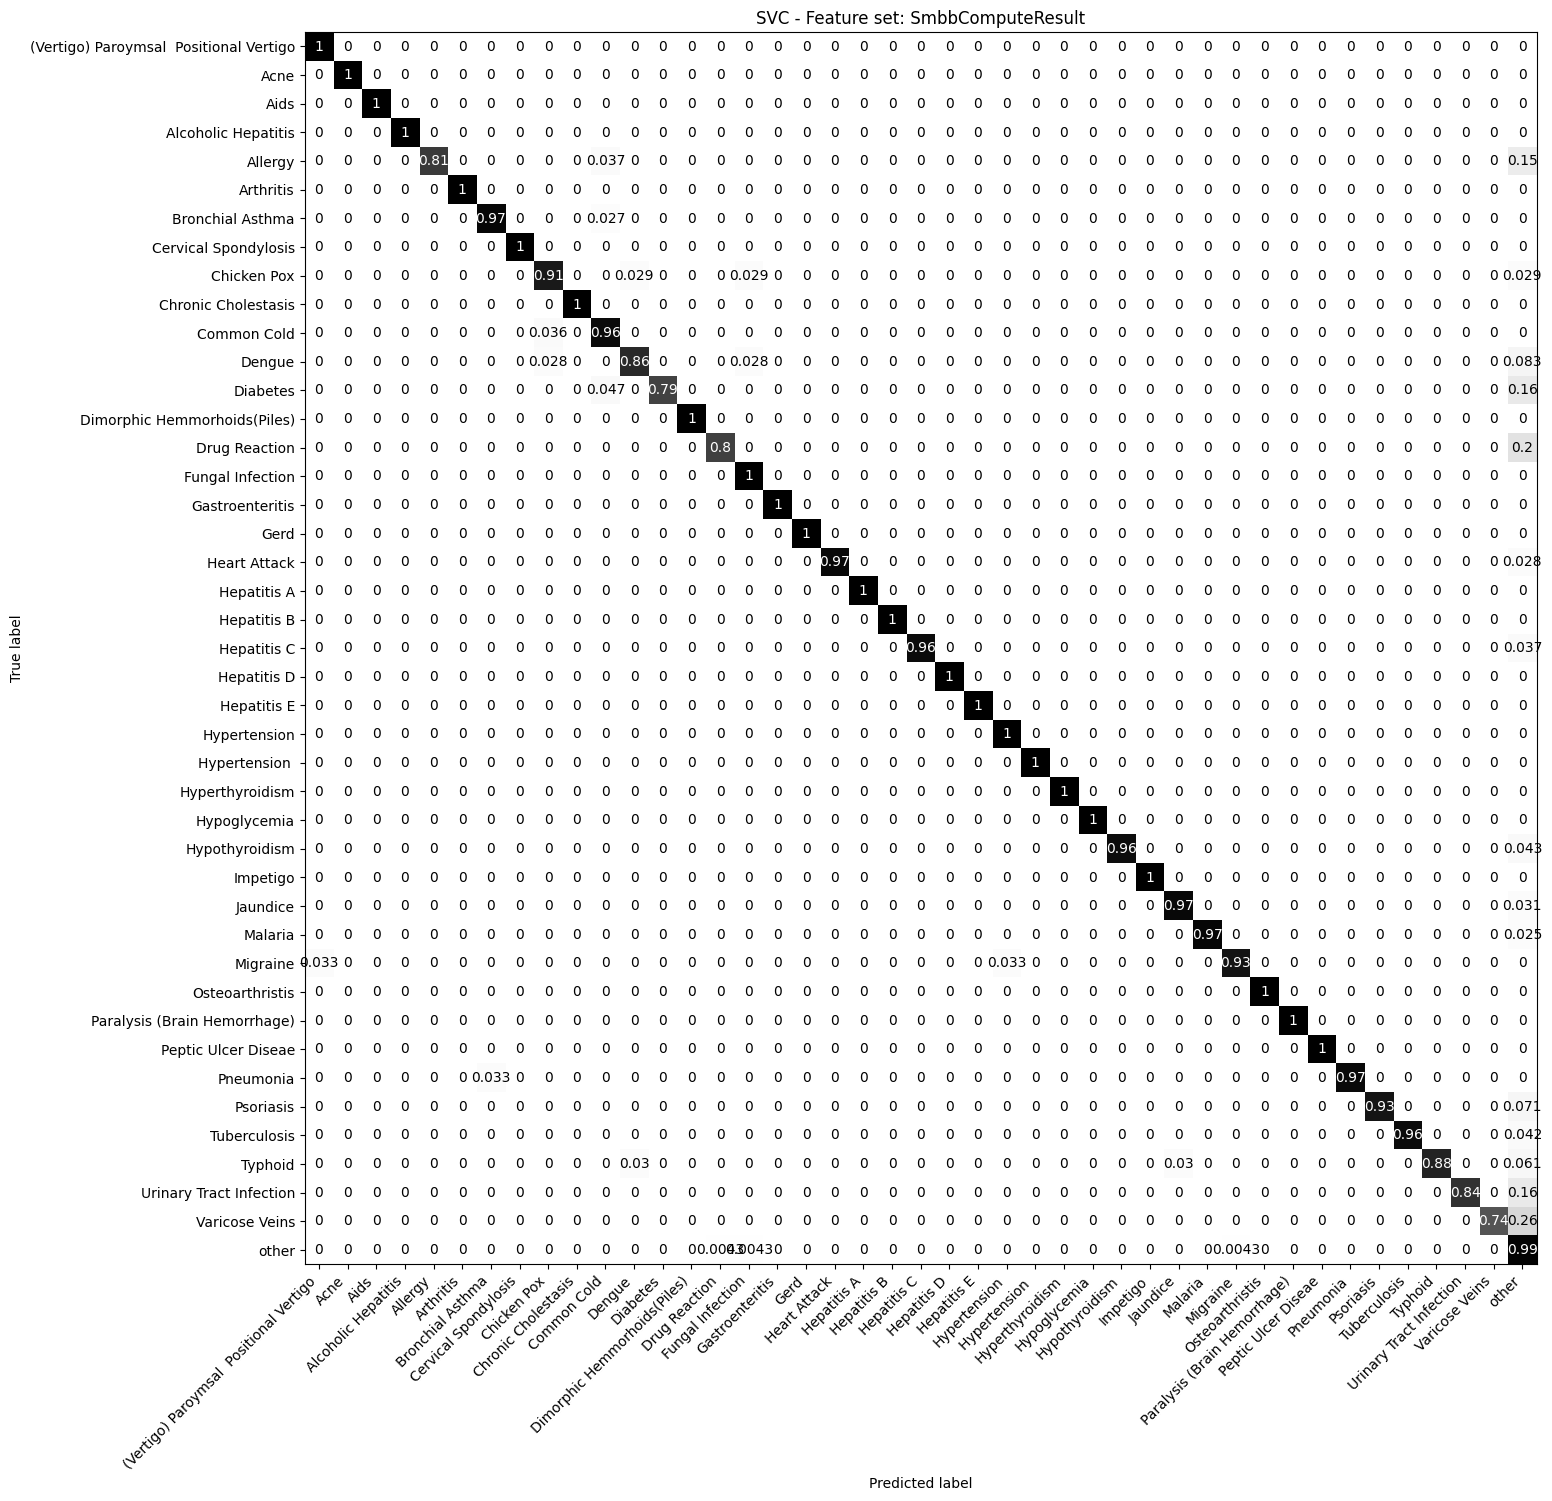

RandomForestClassifier - Feature set: SmbbComputeResult
Accuracy: 0.9666430092264017
F1 score: 0.9665961231971835

SVC - Feature set: SmbbComputeResult
Accuracy: 0.9559971611071683
F1 score: 0.9558866275064963


<Figure size 640x480 with 0 Axes>

In [9]:
# Train and evaluate RandomForestClassifier and SVC for each feature set
for feature in ['SmbbComputeResult']:
    (accuracy_rfc, f1_rfc), (accuracy_svc, f1_svc) = train_evaluate_models(df_train, df_test, feature)
    
    # Print results for RandomForestClassifier
    print(f"RandomForestClassifier - Feature set: {feature}")
    print(f"Accuracy: {accuracy_rfc}")
    print(f"F1 score: {f1_rfc}")
    
    # Print results for SVC
    print(f"\nSVC - Feature set: {feature}")
    print(f"Accuracy: {accuracy_svc}")
    print(f"F1 score: {f1_svc}")
